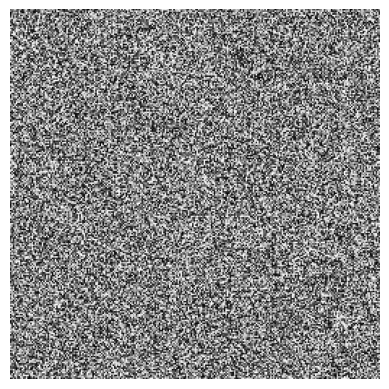

In [17]:
import torch
import matplotlib.pyplot as plt
img_size = 256
key = torch.randint(0, 256, (1, img_size, img_size), dtype=torch.float) / 255.0

# 将 key 张量转换为 numpy 数组，并调整其形状
key_img = key.squeeze().numpy()  # 删除维度为1的维度

# 显示图像
plt.imshow(key_img, cmap='gray')  # 使用灰度颜色图显示
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [18]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class Dataset(Dataset):
    def __init__(self, data_dir, img_size, sharp_transform=None):
        # self.sharp = os.path.join(data_dir, "sharp")
        self.data_dir = data_dir
        self.img_size = img_size
        self.sharp_transform = sharp_transform
        self.key = None
        if len(os.listdir(self.data_dir)) > 50000:
            self.sharp_image_list = os.listdir(self.data_dir)[:95000]
        else:
            self.sharp_image_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.sharp_image_list)

    def __getitem__(self, idx):
        # 加载清晰图片
        global sharp_transformed
        sharp_image_path = os.path.join(self.data_dir, self.sharp_image_list[idx])
        sharp_image = Image.open(sharp_image_path).convert('L')

        # # 为每张图片生成一个随机图像当作密钥
        key = torch.randint(0, 256, (1, self.img_size, self.img_size), dtype=torch.float) / 255.0  # 灰度图像密钥

        # 对清晰图片应用变换
        if self.sharp_transform is not None:
            sharp_transformed = self.sharp_transform(sharp_image)

        # Transform the key to match the image size if needed
        # Here, assuming the key is already in the correct size

        return sharp_transformed, key

In [19]:
from torchvision import transforms
from sklearn.model_selection import train_test_split

def GetDataLoader(data_path, image_size, test_path=None, batch_size=16):
    if test_path is not None:
        data_path = test_path

    sharp_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (1.0,))         # 适用于灰度图像
    ])

    full_dataset = Dataset(data_path, img_size=image_size, sharp_transform=sharp_transform)

    # Split the dataset into training and validation sets
    num_samples = len(full_dataset)
    indices = list(range(num_samples))
    train_indices, val_indices = train_test_split(indices, test_size=0.01, random_state=42)

    # Create the data loaders for training and validation
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    training_loader = DataLoader(
        full_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        pin_memory=True
    )

    validation_loader = DataLoader(
        full_dataset,
        batch_size=batch_size,
        sampler=val_sampler,
        pin_memory=True
    )
    full_loader = DataLoader(
        full_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )
    # print(f"datavarance {np.var(full_dataset.data / 255.0)}")
    print(f"Number of training images: {len(train_indices)}")
    print(f"Number of validation images: {len(val_indices)}")
    print(f"Number of full data images: {num_samples}")
    print(f"Batch size: {batch_size}")

    return training_loader, validation_loader, full_loader

In [20]:
# model
import torch.nn as nn


class ImageCrypt(torch.nn.Module):
    def __init__(self, input_dim=1, num_filter=64, output_dim=1):
        super(ImageCrypt, self).__init__()     # 调用父类的构造函数

        # 加密网络和解密网络均使用下面给出的Generator架构
        self.encryptor = Generator(input_dim * 2, num_filter, output_dim).encoder
        self.decryptor = Generator(input_dim * 2, num_filter, output_dim).decoder
        self.discriminator = Discriminator(input_dim, num_filter)  # 添加判别器
        self.noise_layer = GaussianNoise()

    def forward(self, x, key):
        
        device = x.device
        key_expanded = key.to(device)

        # 加密过程
        encrypted_input = torch.cat([x, key_expanded], dim=1)
        encrypted_image = self.encryptor(encrypted_input)

        # 解密过程
        decrypted_input = torch.cat([encrypted_image, key_expanded], dim=1)
        decrypted_image = self.decryptor(decrypted_input)
        return encrypted_image, decrypted_image

    def encrypt(self, x, key):
        device = x.device
        key_expanded = key.to(device)
        encrypted_input = torch.cat([x, key_expanded], dim=1)
        encrypted_image = self.encryptor(encrypted_input)
        return encrypted_image

    def decrypt(self, encrypted_image, key):
        device = encrypted_image.device
        key_expanded = key.to(device)
        decrypted_input = torch.cat([encrypted_image, key_expanded], dim=1)
        return self.decryptor(decrypted_input)


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filter):
        super(Discriminator, self).__init__()
        self.conv1 = ConvBlock(input_dim, num_filter, kernel_size=4, stride=2, padding=1)
        self.conv2 = ConvBlock(num_filter, num_filter * 2, kernel_size=4, stride=2, padding=1)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4, kernel_size=4, stride=2, padding=1)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8, kernel_size=4, stride=2, padding=1)
        self.final_conv = nn.Conv2d(num_filter * 8, 1, kernel_size=4, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.final_conv(x)
        x = self.sigmoid(x)
        return x


class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.01):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            return x + torch.randn_like(x) * self.sigma
        return x
    # def __init__(self, sigma=0.01):
    #     super(GaussianNoise, self).__init__()
    #     self.sigma = sigma
    #
    # def forward(self, x, rnd_noise):
    #     if self.training:
    #         noise = rnd_noise * torch.randn_like(x)
    #         return x + noise
    #     return x


class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)      # kernel_size卷积核大小，stride卷积步长，padding卷积填充的数量
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, inplace=False)  # 设置 inplace=False
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

      # 前向传播
    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False, use_skip=True):
        super(DeconvBlock, self).__init__()
        self.use_skip = use_skip
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5 if dropout else 0)  # 增加dropout概率以防止过拟合
        self.relu = torch.nn.ReLU(inplace=False)  # 设置 inplace=False
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x, skip_input=None):
        x = self.deconv(self.relu(x))
        if self.batch_norm:
            x = self.bn(x)
        if self.dropout:
            x = self.drop(x)
        if self.use_skip and skip_input is not None:
            x = torch.cat([x, skip_input], 1)  # 将跳过连接的输入合并
        return x


class Generator(nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(  
            ConvBlock(input_dim, num_filter, activation=False, batch_norm=False),
            ConvBlock(num_filter, num_filter * 2),
            ConvBlock(num_filter * 2, num_filter * 4),
            ConvBlock(num_filter * 4, num_filter * 8),
            ConvBlock(num_filter * 8, num_filter * 16, batch_norm=False)
        )
      

        # Decoder
        self.decoder = nn.Sequential(  
            DeconvBlock(num_filter * 16, num_filter * 8),
            DeconvBlock(num_filter * 16, num_filter * 4),
            DeconvBlock(num_filter * 8, num_filter * 2),
            DeconvBlock(num_filter * 4, num_filter),
            DeconvBlock(num_filter * 2, output_dim, batch_norm=False),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
            nn.Conv2d(output_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )
      

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = self.decoder(x)
        out = self.sigmoid(x)  # 使用非就地操作
        return out
    
    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal_(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight, mean, std)





In [21]:
# losses.py
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from numpy.testing import assert_almost_equal
# from torchvision import models
from torchvision.models import VGG16_Weights


# 感知损失
class PerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(PerceptualLoss, self).__init__()
        vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
        self.vgg_layers = nn.Sequential(*list(vgg16)[:16]).eval()
        self.resize = resize

        for param in self.vgg_layers.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        if input.size(1) == 1:
            input = input.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        if self.resize:
            input = nn.functional.interpolate(input, size=(224, 224), mode='bilinear', align_corners=False)
            target = nn.functional.interpolate(target, size=(224, 224), mode='bilinear', align_corners=False)

        input_features = self.vgg_layers(input)
        target_features = self.vgg_layers(target)

        loss = nn.functional.mse_loss(input_features, target_features)
        return loss


# 密钥复合损失
class KeyLoss(nn.Module):
    def __init__(self):
        super(KeyLoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, original, decrypted_correct, decrypted_wrong):
        correct_loss = self.loss(decrypted_correct, original)
        wrong_loss = self.loss(decrypted_wrong, original)
        return correct_loss - wrong_loss  # 直接将 wrong_loss 取负，以实现最大化它的效果


     

In [22]:
# main
import configparser
import os
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
from torch import optim, nn
# from util.tools import makeDir, show_images, save_images
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import vgg16
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg_path = r'./config/ImageCrypt.cfg'
config = configparser.ConfigParser()
config.read(cfg_path)

# 获取训练参数
checkpoints_name = 'Unet-base'
train_data_path = 'D:\dataset\subset'


batch_size = 16
num_epochs = 10
save_epoch = 10
print_epoch = 1
valid_epoch = 10
image_size = 256

In [23]:
np.random.seed(443)
model = ImageCrypt(input_dim=1, num_filter=64, output_dim=1).to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))


L1_loss = nn.L1Loss().to(device)
MSE_loss = nn.MSELoss().to(device)
perceptual_loss = PerceptualLoss().to(device)
key_loss_func = KeyLoss().to(device)
adversarial_loss = nn.BCELoss().to(device)  

lambda_mse = 0.3  # 初始化MSE损失的权重，这些值需要根据模型表现进行调整
lambda_l1 = 0.2  # 初始化L1损失的权重
lambda_key = 0.1  # 初始化KeyLoss的权重
lambda_perceptual = 0.2  # 初始化感知损失的权重

discriminator_optimizer = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [24]:
def showImage(image):
    image = image.squeeze().numpy()  # 删除维度为1的维度
    # 显示图像
    plt.imshow(image, cmap='gray')  # 使用灰度颜色图显示
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

In [27]:
def train_epoch(epoch, train_loader):
    train_data_size = len(train_loader)
    train_data = tqdm(train_loader, total=train_data_size, initial=1, leave=False,
                      desc=f"Epoch {epoch + 1}/{num_epochs}")
    
    for sharp, key in iter(train_data):
        sharp = sharp.to(device)
        key = key.to(device)
        # 生成错误密钥
        wrong_key = torch.randint(0, 256, key.shape, dtype=torch.float).to(device) / 255.0  # 和正确密钥生成方式一样

        optimizer.zero_grad()
        discriminator_optimizer.zero_grad()

        encrypted_image, decrypted_image = model(sharp, key)
        print('encrypted_image')
        showImage(encrypted_image)
        print('decrypted_image')
        showImage(decrypted_image)

        real_outputs = model.discriminator(key)                    # 原始密钥作为‘真’图像输入判别器
        fake_outputs = model.discriminator(encrypted_image.detach())

        real_labels = torch.ones_like(real_outputs).to(device)
        fake_labels = torch.zeros_like(fake_outputs).to(device)

        d_loss_real = adversarial_loss(real_outputs, real_labels)
        d_loss_fake = adversarial_loss(fake_outputs, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        discriminator_optimizer.step()

        # # 加密网络训练
        adv_loss = adversarial_loss(model.discriminator(encrypted_image), real_labels)
        encrypt_loss = MSE_loss(encrypted_image, key)    # 是不是应该把sharp改为key？
        decrypt_loss_l1 = L1_loss(decrypted_image, sharp)
        perceptual_loss_value = perceptual_loss(decrypted_image, sharp)
        key_loss = key_loss_func(sharp, decrypted_image, wrong_key)

        total_loss = (lambda_mse * encrypt_loss + lambda_l1 * decrypt_loss_l1 +
                      lambda_perceptual * perceptual_loss_value - lambda_key * key_loss + adv_loss)

        # 反向传播和优化
        # optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()







In [28]:
train_loader, _, _ = GetDataLoader(data_path='D:\dataset\subset', image_size=image_size, batch_size=batch_size)
discriminator_optimizer = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_epoch(epoch=1, train_loader=train_loader)


Number of training images: 59
Number of validation images: 1
Number of full data images: 60
Batch size: 16


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 256 for tensor number 1 in the list.

In [1]:
import torch

input_tensor = torch.randn(16, 1024, 8, 8)
size = input_tensor.size()
size[0]

16

In [6]:
import torch
import torch.nn as nn

# 定义ConvTranspose2d层
conv_transpose = nn.ConvTranspose2d(
    in_channels=1024,   # 输入通道数
    out_channels=1,  # 输出通道数
    kernel_size=3,    # 卷积核大小
    stride=37,         # 步幅
    padding=3        # 填充
)

# 输入特征图（例如：形状为 (batch_size, 64, 16, 16)）
input_feature_map = torch.randn(16, 1024, 8, 8)

# 上采样后的特征图
upsampled_feature_map = conv_transpose(input_feature_map)
print(upsampled_feature_map.shape) 


torch.Size([16, 1, 256, 256])


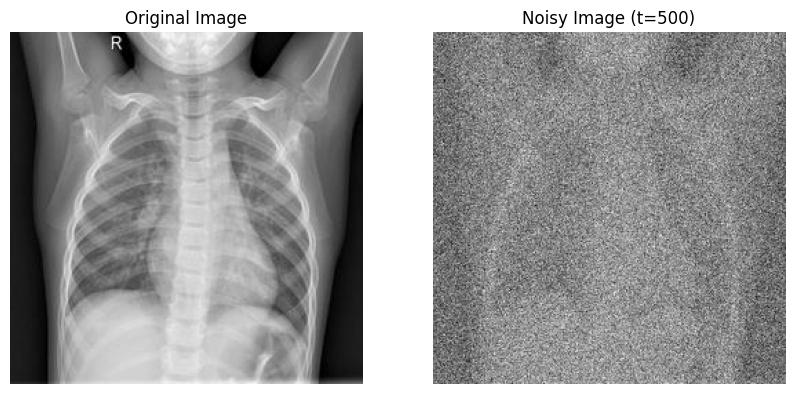

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms


# 从文件中读取图像
image_path = 'D:/dataset/verify_pipeline/IM-0115-0001.jpeg'  # 替换为你的图像路径
image = Image.open(image_path).convert('L')  # 读取图像并转换为灰度图

# 定义转换
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 转换图像为张量
input_image = transform(image).unsqueeze(0)  # 增加一个维度，变成 (1, 1, 256, 256)

# 选择一个时间步长进行测试
t = 500  # 可以调整这个值来改变噪声的程度

# 向图像添加噪声
noise = torch.randn_like(input_image)
noisy_image = noise *0.5 + input_image

# 显示原始图像和添加噪声后的图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image[0, 0].detach().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image[0, 0].detach().numpy(), cmap='gray')
plt.title(f'Noisy Image (t={t})')
plt.axis('off')

plt.show()


Epoch [1/50], Loss: 0.015619139187037945
Epoch [2/50], Loss: 0.0012845458695665002
Epoch [3/50], Loss: 0.002815806306898594
Epoch [4/50], Loss: 0.003472286043688655
Epoch [5/50], Loss: 0.010818145237863064
Epoch [6/50], Loss: 0.0011228752555325627
Epoch [7/50], Loss: 0.009427187964320183
Epoch [8/50], Loss: 0.011224834248423576
Epoch [9/50], Loss: 0.004041822627186775
Epoch [10/50], Loss: 0.0005494579090736806
Epoch [11/50], Loss: 0.0004983477992936969
Epoch [12/50], Loss: 0.013730257749557495
Epoch [13/50], Loss: 0.0061752526089549065
Epoch [14/50], Loss: 0.0034671241883188486
Epoch [15/50], Loss: 0.0034543767105787992
Epoch [16/50], Loss: 0.00047257731785066426
Epoch [17/50], Loss: 0.0009580366895534098
Epoch [18/50], Loss: 0.0011111379135400057
Epoch [19/50], Loss: 0.003752530086785555
Epoch [20/50], Loss: 0.0005949877668172121
Epoch [21/50], Loss: 0.00945640541613102
Epoch [22/50], Loss: 0.000350195070495829
Epoch [23/50], Loss: 0.004398958757519722
Epoch [24/50], Loss: 0.007182562

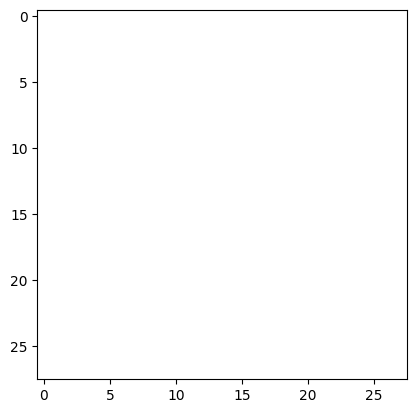

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 定义UNet模型
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# DDPM的前向和反向过程
class DDPM(nn.Module):
    def __init__(self, beta1, beta2, timesteps, model):
        super(DDPM, self).__init__()
        self.beta1 = beta1
        self.beta2 = beta2
        self.timesteps = timesteps
        self.model = model

        self.alpha = 1.0 - self.beta1
        self.alpha_bar = np.cumprod([self.alpha] * self.timesteps)

    def forward_process(self, x0, t):
        noise = torch.randn_like(x0).to(x0.device)
        t = t.cpu()
        x = self.alpha_bar[t]
        sqrt_alpha_bar_t = torch.sqrt(torch.tensor(x).float()).view(-1, 1, 1, 1)
        sqrt_alpha_bar_t = sqrt_alpha_bar_t.to(x0.device)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - torch.tensor(self.alpha_bar[t]).float()).view(-1, 1, 1, 1).to(x0.device)
        xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
        return xt, noise

    def reverse_process(self, xt, t):
        return self.model(xt)

    def loss(self, x0, t):
        xt, noise = self.forward_process(x0, t)
        noise_pred = self.reverse_process(xt, t)
        return nn.MSELoss()(noise_pred, noise)

# 数据准备
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 模型、损失函数和优化器
model = UNet(in_channels=1, out_channels=1).to(device)
ddpm = DDPM(beta1=0.1, beta2=0.2, timesteps=1000, model=model).to(device)
optimizer = optim.Adam(ddpm.parameters(), lr=0.001)

# 训练循环
num_epochs = 50
for epoch in range(num_epochs):
    for images, _ in dataloader:
        images = images.to(device)
        batch_size = images.size(0)
        t = torch.randint(0, ddpm.timesteps, (batch_size,)).to(device)
        loss = ddpm.loss(images, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 生成图像
ddpm.eval()
with torch.no_grad():
    # 从随机噪声开始生成图像
    xt = torch.randn((1, 1, 28, 28)).to(device)
    for t in reversed(range(ddpm.timesteps)):
        xt = ddpm.reverse_process(xt, torch.tensor([t]).to(device))

    generated_image = xt.squeeze().cpu().numpy()  # 移动到CPU上再转换为NumPy数组
    plt.imshow(generated_image, cmap='gray')
    plt.show()



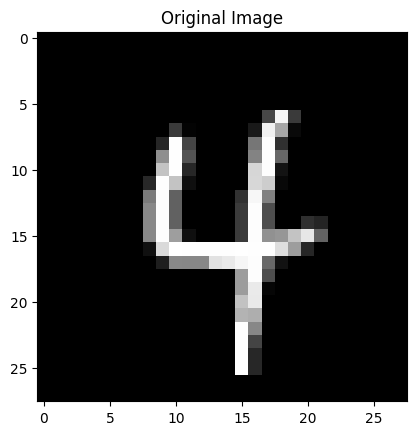

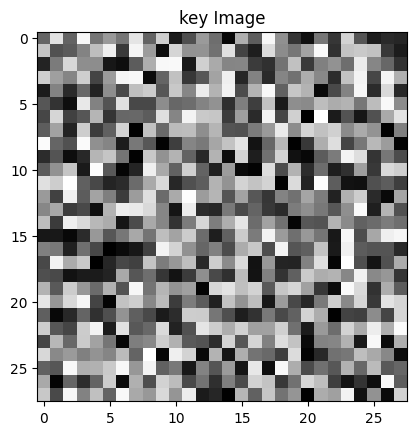

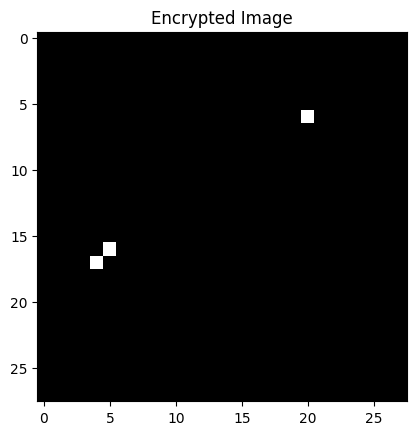

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 定义多层1x1卷积网络
class EncryptNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(EncryptNet, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, hidden_channels, kernel_size=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = hidden_channels
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# 数据准备
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 初始化模型
in_channels = 2
hidden_channels = 1  # 可以调整隐藏通道数
num_layers = 1 # 可以调整层数
model = EncryptNet(in_channels, hidden_channels, num_layers).to(device)


# 选择一张图像进行“加密”
data_iter = iter(dataloader)
images, _ = next(data_iter)
image = images[0].unsqueeze(0).to(device)
key = torch.randint(0, 256, image.shape, dtype=torch.float).to(device) # 选择第一张图像并添加batch维度
input = torch.cat([key, image], dim=1)

# 显示原始图像
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.title("Original Image")
plt.show()
plt.imshow(key.squeeze().cpu().numpy(), cmap='gray')
plt.title("key Image")
plt.show()



# 通过模型进行“加密”
with torch.no_grad():
    encrypted_image = model(input)

# 显示“加密”后的图像
plt.imshow(encrypted_image.squeeze().cpu().numpy(), cmap='gray')
plt.title("Encrypted Image")
plt.show()


100%|██████████| 170498071/170498071 [00:15<00:00, 11010534.37it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Epoch [1/10], Loss: 0.0382431223988533
Epoch [2/10], Loss: 0.02287038415670395
Epoch [3/10], Loss: 0.022053739055991173
Epoch [4/10], Loss: 0.014479649253189564
Epoch [5/10], Loss: 0.023678524419665337
Epoch [6/10], Loss: 0.023117104545235634
Epoch [7/10], Loss: 0.030971363186836243
Epoch [8/10], Loss: 0.01868501864373684
Epoch [9/10], Loss: 0.021752312779426575
Epoch [10/10], Loss: 0.014942571520805359


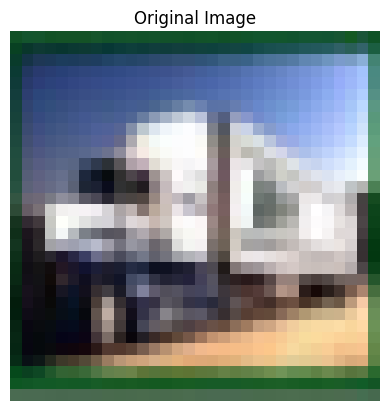

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


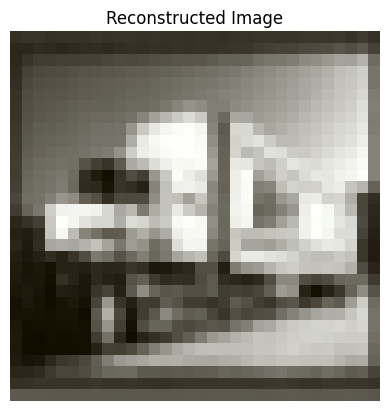

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 定义自动编码器
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=1),  # 降通道
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=1),  # 恢复通道
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 数据准备
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 初始化模型和优化器
model = AutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in dataloader:
        optimizer.zero_grad()
        encoded, decoded = model(images.to(device))
        loss = criterion(decoded, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    for images, _ in dataloader:
        encoded, decoded = model(images)
        break

# 显示原始图像和重建图像
def show_image(tensor, title):
    image = tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5) + 0.5  # 反标准化
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 显示原始图像
show_image(images[0], 'Original Image')

# 显示重建图像
show_image(decoded[0], 'Reconstructed Image')
